In [40]:
import geemap
import ee
import folium
import geopandas as gpd

In [41]:
ee.Initialize()

In [61]:
datadir = 'C:/Users/jtrum/world_bank/data/'

# Define the path to your GeoJSON file
aoi_path = datadir + 'luanda2clean.geojson'

# Load the GeoJSON as a Feature
aoi = geemap.geojson_to_ee(aoi_path)

# Create a map
Map = geemap.Map()
#choose a different basemap
Map.add_basemap('CartoDB.DarkMatter')

# Load the ESA Land Cover data
esa = ee.ImageCollection("ESA/WorldCover/v100").first()

# Filter the data to your AOI
esa = esa.clip(aoi)

esa_vis = {'bands': ['Map']}

# Add the ESA Land Cover layer to the map
Map.addLayer(esa, esa_vis, "ESA Land Cover")

# add legend with colors chosen from self-defined palette
Map.add_legend(builtin_legend='ESA_WorldCover', 
               #legend_title="ESA Land Cover", 
               #layer_name="ESA Land Cover", 
               colors=['#05450a', '#086a10', '#54a708', '#78d203', '#009900', '#c6b044', '#dcd159', '#dade48', '#fbff13','#d5n5n5', '#129279'],
               labels=['trees', 'shrublands', 'grasslands', 'croplands', 'built-up', 'bare', 'snow and ice', 'water bodies', 'herbaceous vegetation', 'mangroves', 'moss and lichen']
               )


#start the zoom at the center of the AOI
Map.centerObject(aoi, 10)



# Display the map
Map


Map(center=[-8.980207755364754, 13.310742868350161], controls=(WidgetControl(options=['position', 'transparent…

In [62]:
df = geemap.image_area_by_group(esa, scale=1000, denominator=1e6, decimal_places=4, verbose=True)

Calculating area for group 10 ...
Calculating area for group 20 ...
Calculating area for group 30 ...
Calculating area for group 40 ...
Calculating area for group 50 ...
Calculating area for group 60 ...
Calculating area for group 80 ...
Calculating area for group 90 ...
Calculating area for group 95 ...


In [36]:
df.dtypes

area          float64
percentage    float64
dtype: object

In [63]:
df['percentage'] = df['percentage']*100

# reset the index and rename the columns to be the name of the Land Cover Type
df = df.reset_index().rename(columns={'group': 'type'})


# Create a mapping dictionary with numbers as strings
type_mapping = {
    '10': 'Trees',
    '20': 'Shrublands',
    '30': 'Grasslands',
    '40': 'Croplands',
    '50': 'Built-Up',
    '60': 'Barren',
    '70': 'Snow and Ice',
    '80': 'Water Bodies',
    '90': 'Herbaceous Wetlands',
    '95': 'Mangroves',
    '100': 'Moss and Lichen'
}

# Use the mapping dictionary to replace values in the 'type' column
df['type'] = df['type'].replace(type_mapping)
df
                                

,type,area,percentage
0,Trees,42.6993,1.75
1,Shrublands,10.7903,0.44
2,Grasslands,1460.9425,59.87
3,Croplands,6.7740,0.28
4,Built-Up,505.1714,20.70
5,Barren,135.6323,5.56
6,Water Bodies,37.0484,1.52
7,Herbaceous Wetlands,195.5900,8.02
8,Mangroves,45.3820,1.86


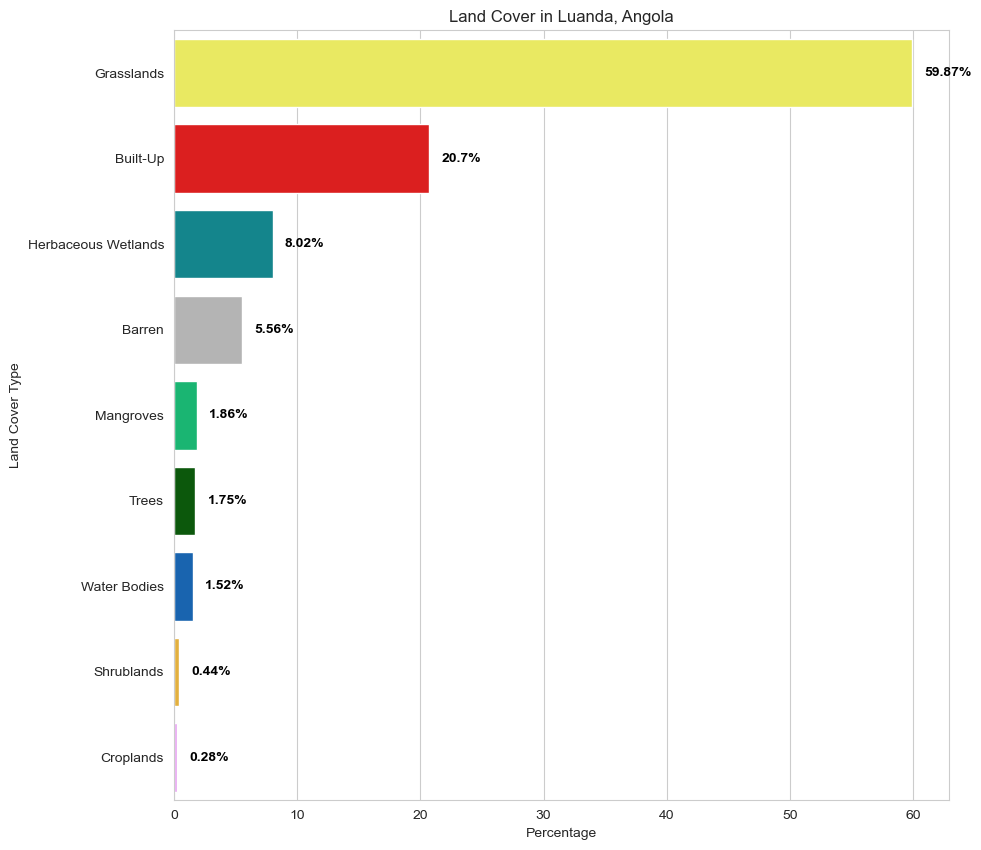

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make a color dictionary of the colors from the ESA Land Cover legend
color_dict = {
    'Trees': '#006400',
    'Shrublands': '#FFBB22',
    'Grasslands': '#FFFF4C',
    'Croplands': '#F096FF',
    'Built-Up': '#FA0000',
    'Barren': '#B4B4B4',
    'Snow and Ice': '#F0F0F0',
    'Water Bodies': '#0064C8',
    'Herbaceous Wetlands': '#0096A0',
    'Mangroves': '#00CF75',
    'Moss and Lichen': '#FAE6A0'
}

# Sort the DataFrame by percentage in descending order
df = df.sort_values('percentage', ascending=False)

# Set the figure size
plt.figure(figsize=(10, 10))

# Create the barplot
sns.barplot(x='percentage', y='type', data=df, palette=color_dict)

# Add labels at the end of each bar
for i, v in enumerate(df['percentage']):
    plt.text(v + 1, i, str(round(v, 2)) + '%', va='center', color='black', fontweight='bold')

# Customize labels and title
plt.xlabel('Percentage')
plt.ylabel('Land Cover Type')
plt.title('Land Cover in Luanda, Angola')

# Show the plot
plt.show()

In [81]:
# Define the location (Luanda, Angola) and Area of Interest (AOI)
# Replace the coordinates in the Point and Polygon geometries with those for Luanda, Angola.
Luanda = ee.Geometry.Point([13.2343, -8.8383])
Luanda_Extent = ee.Geometry.Polygon(
    [[[13.1643, -8.9421],
      [13.1643, -8.7278],
      [13.3597, -8.7278],
      [13.3597, -8.9421]]])
# Define the city name and convert it to lowercase
city_name = "Luanda"
id = "Luanda"
# Create Water Mask
WaterMask = ee.Image('COPERNICUS/S1_GRD')
waterMask = WaterMask.select('transition')
blank = ee.Image(0)
nonWater = blank.addBands(waterMask).unmask().select('transition').eq(0).rename('non_water')
# Create Slope Mask
srtm = ee.Image('USGS/SRTMGL1_003')
slope = ee.Terrain.slope(srtm)
Grade15 = slope.gt(15)
gtGrade15 = Grade15.updateMask(Grade15.neq(0))
slopeMask = gtGrade15.clip(Luanda_Extent).unmask(0).subtract(1).multiply(-1)
# Load Sentinel-1 C-band SAR Ground Range collection (log scaling, VV co-polar)
collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
              .filterBounds(Luanda)
              .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
              .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
              .select('VV'))
# Filter by date
during_flood_collection = collection.filterDate('2017-03-14', '2017-03-29')
during_flood = (during_flood_collection.first()
                .clip(Luanda_Extent)
                .updateMask(nonWater)
                .updateMask(slopeMask))
before_flood_collection = collection.filterDate('2016-08-01', '2016-09-30')
before_flood = (before_flood_collection.median()
                .clip(Luanda_Extent)
                .updateMask(nonWater)
                .updateMask(slopeMask))
# Define a smoothing box (30m is 3x size of S1 pixel)
smoothing_box = 30
# Create difference images (during flood - before flood)
difference_smoothed = (during_flood
                       .focal_median(smoothing_box, 'square', 'meters')
                       .subtract(before_flood.focal_median(smoothing_box, 'square', 'meters')))
difference_raw = during_flood.subtract(before_flood)
# Resample difference raster
difference_smoothed_resampled = (difference_smoothed
                                 .resample('bilinear')
                                 .reproject(crs=difference_smoothed.projection()))
# Calculate Upper and Lower Thresholds
UpperThreshold = (difference_smoothed_resampled
                  .reduceRegion(reducer=ee.Reducer.percentile([6]),
                                geometry=Luanda_Extent,
                                scale=10,
                                maxPixels=1e9)
                  .get('VV'))
LowerThreshold = (difference_smoothed_resampled
                  .reduceRegion(reducer=ee.Reducer.percentile([94]),
                                geometry=Luanda_Extent,
                                scale=10,
                                maxPixels=1e9)
                  .get('VV'))
print(UpperThreshold.getInfo())
print(LowerThreshold.getInfo())
# Make Difference Darker Rasters
difference_darker_smoothed_thresholded = difference_smoothed_resampled.lt(UpperThreshold)
difference_darker_thresholded = difference_raw.lt(UpperThreshold)
# Make Difference Brighter Rasters
difference_brighter_smoothed_thresholded = difference_smoothed_resampled.gt(LowerThreshold)
difference_brighter_thresholded = difference_raw.gt(LowerThreshold)
# Display map (you can visualize it in the GEE Code Editor)
Map = ee.Map()
Map.centerObject(Luanda, 13)
Map.addLayer(before_flood, {'min': -30, 'max': 0}, 'Before Flood', 1)
Map.addLayer(during_flood, {'min': -30, 'max': 0}, 'During Flood', 1)
Map.addLayer(difference_raw, {'min': -10, 'max': 10}, 'Difference - Raw', 0)
Map.addLayer(difference_smoothed, {'min': -10, 'max': 10}, 'Difference - Smoothed', 0)
Map.addLayer(difference_smoothed_resampled, {'min': -10, 'max': 10}, 'Difference - Smoothed & Resampled', 1)
# Save maps to Google Drive or export as assets as needed

EEException: Image.load: Asset 'COPERNICUS/S1_GRD' is not an Image.

In [91]:
import spyndex
import geemap
import ee , eemont

In [112]:
import ee
import geemap

# Define the path to your GeoJSON file
datadir = 'C:/Users/jtrum/world_bank/data/'
aoi_path = datadir + 'luanda2clean.geojson'

# Load the GeoJSON as a FeatureCollection
aoi = ee.FeatureCollection(aoi_path)

# Create a map
Map = geemap.Map()
Map.centerObject(aoi, 10)

# Load the Sentinel-2 image collection
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(aoi) \
    .filterDate('2019-01-01', '2019-12-31') \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10) \
    .first() \
    .multiply(0.0001)

# Compute the NDVI index
ndvi = sentinel.normalizedDifference(['B8', 'B4'])

# Add the NDVI band to the image
img = sentinel.addBands(ndvi.rename('NDVI'))

# Add the NDVI layer to the map
Map.addLayer(img.select('NDVI'), {"min": -1, "max": 1, "palette": ['red', 'white', 'green']}, "NDVI")

# Display the map
Map


EEException: Collection.loadTable: Collection asset 'C:/Users/jtrum/world_bank/data/luanda2clean.geojson' not found.

In [113]:
aoi_path = datadir + 'luanda2clean.geojson'
aoi = ee.FeatureCollection(aoi)
coords = aoi.geometry().coordinates().getInfo()[0]

roi = ee.Geometry.Point([13.230162, -8.814921])

sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filterBounds(roi)\
    .filterDate('2019-01-01', '2019-12-31')\
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)\
    .first()\
    .multiply(0.0001)

idx = spyndex.computeIndex(
    index = ['NDVI'], 
    params = {
        "R": sentinel["B4"],
        "N": sentinel["B8"],
        "G": sentinel["B3"],
        "B": sentinel["B2"]
        }
)

img = sentinel.addBands(idx)

Map = geemap.Map()
Map.centerObject(img, 10)
Map.addLayer(img['NDVI'], {"min":-1, "max":1, "palette":['red', 'white', 'green']}, "NDVI")
Map

EEException: Collection.loadTable: Collection asset 'C:/Users/jtrum/world_bank/data/luanda2clean.geojson' not found.

In [92]:
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filterBounds(roi)\
    .filterDate('2019-01-01', '2019-12-31')\
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)\
    .first()\
    .multiply(0.0001)

In [95]:
idx = spyndex.computeIndex(index = 'NDVI', 
                           params = {"R": sentinel["B4"],
                                     "N": sentinel["B8"],
                                     "G": sentinel["B3"],
                                     "B": sentinel["B2"]
                                     })

In [96]:
img = sentinel.addBands(idx)

In [98]:
Map = geemap.Map()
Map.centerObject(img, 10)
Map.addLayer(img['NDVI'], {"min":-1, "max":1, "palette":['red', 'white', 'blue']}, "NDVI")
Map

EEException: GeometryConstructors.Polygon, argument 'coordinates': Invalid type.
Expected type: List<Object>.
Actual type: FeatureCollection.

In [109]:
import ee
import geopandas as gpd
import geemap

# Define the path to your GeoJSON file
datadir = 'C:/Users/jtrum/world_bank/data/'
aoi_path = datadir + 'luanda2clean.geojson'

# Load the GeoJSON file locally using geopandas
aoi_gdf = gpd.read_file(aoi_path)

# Convert the geopandas GeoDataFrame to a FeatureCollection for Earth Engine
aoi = ee.FeatureCollection(aoi_gdf.__geo_interface__)

# Rest of your code remains the same
sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filterBounds(aoi)\
    .filterDate('2019-01-01', '2019-12-31')\
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)\
    .first()\
    .multiply(0.0001)

idx = spyndex.computeIndex(index=['VARI', 'NDWI', 'NDVI'], 
                           params={"R": sentinel.select("B4"),
                                   "N": sentinel.select("B8"),
                                   "G": sentinel.select("B3"),
                                   "B": sentinel.select("B2")
                                   })

img = sentinel.addBands(idx)

Map = geemap.Map()
Map.centerObject(img, 10)
Map.addLayer(img.select('NDVI'), {"min": -1, "max": 1, "palette": ['red', 'white', 'blue']}, "NDVI")
Map.addLayer(img.select('NDWI'), {"min": -1, "max": 1, "palette": ['red', 'white', 'blue']}, "NDWI")
Map.addLayer(img.select('VARI'), {"min": -1, "max": 1, "palette": ['red', 'white', 'blue']}, "VARI")
Map


EEException: Image.select: Pattern 'NDVI' did not match any bands.